In [1]:
import sys
# sys.path.insert(0, '../../')
import rasterio
import numpy as np
from pathlib import Path
import rioxarray
import rasterio

In [2]:
%load_ext autoreload

In [3]:
RASTER_PATH = Path("../../data/geolifeclef-2022")
# RASTER_PATH = "s3://datasets-sdm/geoLifeCLEF/rasters/"

BUCKET_NAME = 'datasets-sdm'
folder = 'geoLifeCLEF/rasters'
s3_raster_path = 's3://{}/{}/'.format(BUCKET_NAME, folder)

In [4]:
%autoreload 2
from environmental_raster import PatchExtractor

## Test stuff -- ignore

In [200]:
filename = s3_raster_path + "{}/{}_{}.tif".format("bio_11", "bio_11", "USA")
# filename = s3_raster_path + "{}/{}_{}.tif".format("cecsol", "cecsol", "USA")

MIN_ALLOWED_VALUE = -10000
nan = None

# with rasterio.vrt.WarpedVRT(filename, crs="EPSG:32610") as src:
#     # self.dataset = dataset
#     raster = dataset.read(1, masked=True, out_dtype=np.float32)
src = rasterio.open(filename, nodata=nan)

x_min = src.bounds.left
y_min = src.bounds.bottom
x_resolution = src.res[0]
y_resolution = src.res[1]
n_rows = src.height
n_cols = src.width

# loading the raster
raster = np.squeeze(src.read())
src.close()

raster = raster.astype(float)

# value bellow min_value are considered incorrect and therefore no_data
raster[raster < MIN_ALLOWED_VALUE] = None
raster[np.isnan(raster)] = None
#convert to 0-255, and then to uint8
raster = (255 * (raster - np.nanmin(raster)) / (np.nanmax(raster) - np.nanmin(raster))).astype(np.uint8)
raster

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [35]:
np.nanmax(raster), np.nanmin(raster), np.nanstd(raster), np.nanmean(raster)

(255, 0, 62.41662445487879, 40.128194853020986)

(array([[3237.,    0.,    0., ...,    0.,    0.,    0.],
        [3236.,    0.,    0., ...,    0.,    0.,    0.],
        [3234.,    0.,    0., ...,    0.,    0.,    0.],
        ...,
        [2820.,  113.,  268., ...,    0.,    0.,    0.],
        [2829.,  110.,  266., ...,    0.,    0.,    0.],
        [2828.,  111.,  266., ...,    0.,    0.,    0.]]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 7200 BarContainer objects>)

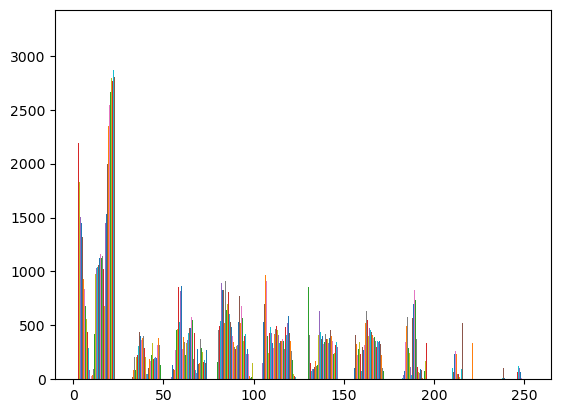

In [202]:
plt.hist(raster)

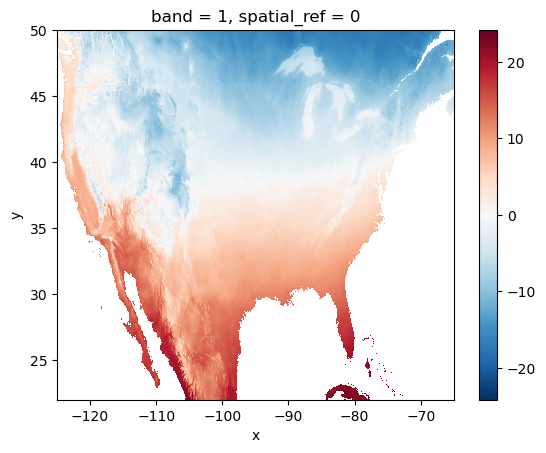

In [34]:
rds = None
filename = s3_raster_path + "{}/{}_{}.tif".format("bio_11", "bio_11", "USA")
with rasterio.Env():
    with rasterio.open(filename, "r") as src:
        with rasterio.vrt.WarpedVRT(src, crs="EPSG:4326") as vrt:
            rds = rioxarray.open_rasterio(vrt, masked=True)
            # rds = rds.rio.reproject("EPSG:32610", nodata=None)
            rds.sel(band=1).plot.imshow()
            
        

<xarray.DataArray (band: 1, y: 22036, x: 31441)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * x            (x) float64 2.936e+05 2.939e+05 ... 7.275e+06 7.275e+06
  * y            (y) float64 7.326e+06 7.326e+06 ... 2.433e+06 2.433e+06
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:       Area
    STATISTICS_MAXIMUM:  385
    STATISTICS_MEAN:     nan
    STATISTICS_MINIMUM:  0
    STATISTICS_STDDEV:   nan
    scale_factor:        1.0
    add_offset:          0.0


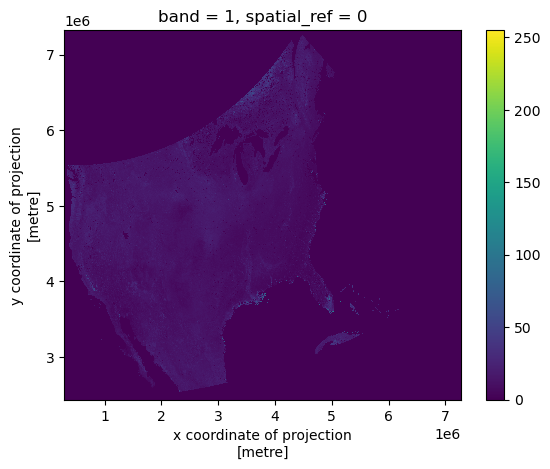

In [5]:
raster = None
filename = s3_raster_path + "{}/{}_{}.tif".format("cecsol", "cecsol", "USA")
# filename = s3_raster_path + "{}/{}_{}.tif".format("bio_4", "bio_4", "USA")
dst_crs = 'EPSG:32610'

with rasterio.Env():
    with rasterio.open(filename, "r") as f:

        raster = rioxarray.open_rasterio(f, masked=True)#.rio.clip([mask_geom], from_disk=True)
        raster = raster.rio.reproject(dst_crs)

print(raster)
#convert to 0-255, and then to uint8
raster.data = (255 * (raster.data - np.nanmin(raster.data)) / (np.nanmax(raster.data) - np.nanmin(raster.data))).astype(np.uint8)
# raster.data = raster.data.filled(0)
raster.sel(band=1).plot.imshow()

In [20]:
len(raster.band)

1

In [7]:
raster.values.mean(), raster.values.std()

(4.459760700269223, 6.987447917277084)

In [126]:
import shapely
point_geom = shapely.geometry.mapping(shapely.geometry.Point(berkeley))
point_geom

AttributeError: module 'shapely' has no attribute 'geometry'

In [31]:
import IPython
import torch
import torchvision.transforms as T

to_pil = T.ToPILImage()


t = torch.from_numpy(raster)
display = to_pil(t)
    

In [50]:
display.show()

## Using PatchExtractor Locally

In [3]:
import shapely.geometry

dst_crs = 'epsg:32610'
side_len_m = 50000
side_len = side_len_m / (111.11 * 1000)
buf = 0.1 # to take care of warping issues
berkeley = (-122.240558, 37.90588)
point_geom = shapely.geometry.mapping(shapely.geometry.Point(berkeley))

# Grid points are in 4326 -> move to 32610
# point_geom = rasterio.warp.transform_geom("epsg:4326", dst_crs, point_geom)
# point_geom = rasterio.warp.transform_geom(self.crs, dst_crs, point_geom)

#Convert the point to a shape
point_shape = shapely.geometry.shape(point_geom)
#Create a square out of it with side_length = buffer*2
mask_shape = point_shape.buffer(side_len * (1+buf)).envelope
# mask_shape = point_shape.buffer(0.025).envelope
mask_geom = shapely.geometry.mapping(mask_shape)
mask_geom

{'type': 'Polygon',
 'coordinates': (((-122.7355629500495, 37.410875049950505),
   (-121.74555304995049, 37.410875049950505),
   (-121.74555304995049, 38.4008849500495),
   (-122.7355629500495, 38.4008849500495),
   (-122.7355629500495, 37.410875049950505)),)}

In [24]:
# local_path = "../../data/geolifeclef-2022/rasters/cecsol/cecsol_USA.tif"
local_path = "../../data/geolifeclef-2022/rasters/bdticm/bdticm_USA.tif"

with rasterio.Env():
    with rasterio.open(local_path, "r") as f:
            # rds = rioxarray.open_rasterio(f, bbox=mask_geom['coordinates'], crop=True)
            rds = rioxarray.open_rasterio(f,masked=True)
            
rds.dtype

dtype('float64')

In [33]:
# r = rds.rio.clip([mask_geom], from_disk=True)
# aoi = r.rio.reproject(dst_crs)

aoi = rds.rio.clip([mask_geom], from_disk=True).rio.reproject(dst_crs)
# aoi = r.rio.reproject(dst_crs)

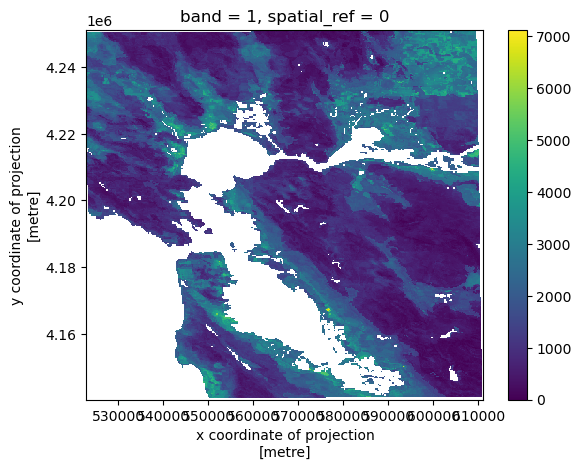

In [34]:
aoi.plot()

In [37]:
aoi.values.shape, aoi.rio.crs.data, rds.rio.crs.data, np.nanmin(aoi.values), np.nanmax(aoi.values)

((1, 531, 423), {'init': 'epsg:32610'}, {'init': 'epsg:4326'}, 0.0, 7123.0)

In [42]:
#aoi.data = (255 * (aoi.data - np.nanmin(aoi.data)) / (np.nanmax(aoi.data) - np.nanmin(aoi.data)))
aoi.data /= 255
np.nanmin(aoi.values), np.nanmax(aoi.values)

(0.0, 27.933333333333334)

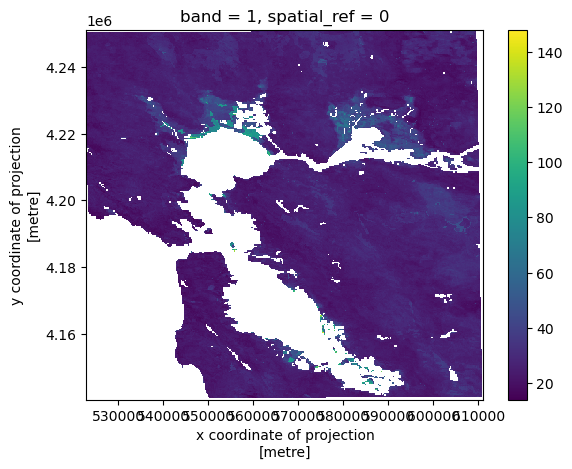

In [24]:
aoi.plot()

In [59]:
np.iinfo(np.int32).min / 2**24

-128.0

In [25]:
rds.encoding

{'dtype': 'int32',
 '_FillValue': -2147483647.0,
 'grid_mapping': 'spatial_ref',
 'source': '../../data/geolifeclef-2022/rasters/bdticm/bdticm_USA.tif',
 'rasterio_dtype': 'int32'}

In [41]:
rasterio.dtypes.get_minimum_dtype(aoi.values)

'float64'

In [44]:
np.nanmin(rds.values), np.nanmax(rds.values), np.nanmean(rds.values), np.nanstd(rds.values)

(0.0, 112467.0, 2632.716751534344, 3209.621533299418)

In [66]:
import torch
import torchvision.transforms as T

side_px = 512
#Now do a center-crop for less than the smaller size by buf
t = torch.from_numpy(aoi.values.astype(np.uint8))

smallest_side = min(t.shape[1:3]) #for 3d tensor

crop_size = int(smallest_side * (1-buf))
postprocess = T.Compose ([T.CenterCrop((crop_size)),
                                     T.Resize((side_px,side_px))])

t = postprocess(t)

In [67]:
t.shape

torch.Size([1, 512, 512])

In [68]:
import IPython
import torch
import torchvision.transforms as T

to_pil = T.ToPILImage()

display = to_pil(t)
# display.show()
display.save('test.png')

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.3)
# plt.suptitle("Daily closing prices", fontsize=18, y=0.95)

# loop through the length of tickers and keep track of index
for i in range (patch.shape[0]):
    RGB_image = patch[i].unsqueeze(dim=0) * 3 #-> Fake convert to RGB
    # add a new subplot iteratively
    ax = plt.subplot(patch.shape[0], 1, i + 1)
    ax.imshow(RGB_image.permute(1, 2, 0))
    ax.axis('off')

In [31]:
import gc
del rds, r, aoi
gc.collect()

491

## Using environmental_raster functions

In [5]:

BUCKET_NAME = 'datasets-sdm'
folder = 'geoLifeCLEF/rasters'
s3_raster_path = 's3://{}/{}/'.format(BUCKET_NAME, folder)

In [6]:
%autoreload 2
from environmental_raster import PatchExtractor


In [7]:
print(s3_raster_path)
extractor = PatchExtractor(s3_raster_path, side_len_m=50000, side_px=512, out_dtype="float")
# extractor.append("bio_1", display=False)
# extractor.add_all_bioclimatic_rasters()
extractor.add_all_rasters()

s3://datasets-sdm/geoLifeCLEF/rasters/
Opening Raster file for  bio_1
Completed Setup of Raster bio_1 
Opening Raster file for  bio_2
Completed Setup of Raster bio_2 
Opening Raster file for  bio_3
Completed Setup of Raster bio_3 
Opening Raster file for  bio_4
Completed Setup of Raster bio_4 
Opening Raster file for  bio_5
Completed Setup of Raster bio_5 
Opening Raster file for  bio_6
Completed Setup of Raster bio_6 
Opening Raster file for  bio_7
Completed Setup of Raster bio_7 
Opening Raster file for  bio_8
Completed Setup of Raster bio_8 
Opening Raster file for  bio_9
Completed Setup of Raster bio_9 
Opening Raster file for  bio_10
Completed Setup of Raster bio_10 
Opening Raster file for  bio_11
Completed Setup of Raster bio_11 
Opening Raster file for  bio_12
Completed Setup of Raster bio_12 
Opening Raster file for  bio_13
Completed Setup of Raster bio_13 
Opening Raster file for  bio_14
Completed Setup of Raster bio_14 
Opening Raster file for  bio_15
Completed Setup of Rast

In [28]:
extractor.dump_metadata()

[bio_1]  'min_val':-7.0958333015441895, 'max_val':27.608333587646484, 'mean'=10.678206443786621, 'std'=6.177802562713623, 'nan'=-3.3999999521443642e+38, type=float32
[bio_2]  'min_val':1.0, 'max_val':22.233333587646484, 'mean'=13.550623893737793, 'std'=2.5262041091918945, 'nan'=-3.3999999521443642e+38, type=float32
[bio_3]  'min_val':20.337738037109375, 'max_val':100.0, 'mean'=37.29763412475586, 'std'=9.503908157348633, 'nan'=-3.3999999521443642e+38, type=float32
[bio_4]  'min_val':0.0, 'max_val':1414.1912841796875, 'mean'=873.933837890625, 'std'=233.8889923095703, 'nan'=-3.3999999521443642e+38, type=float32
[bio_5]  'min_val':0.5, 'max_val':46.20000076293945, 'mean'=29.70604133605957, 'std'=4.532764911651611, 'nan'=-3.3999999521443642e+38, type=float32
[bio_6]  'min_val':-27.399999618530273, 'max_val':20.700000762939453, 'mean'=-7.717265605926514, 'std'=8.616811752319336, 'nan'=-3.3999999521443642e+38, type=float32
[bio_7]  'min_val':1.0, 'max_val':51.69999694824219, 'mean'=37.4232597

### Memory cleanup (when needed)

In [108]:
import gc
# del extractor
extractor.clean()
gc.collect()

66026

### Can also add them one by one

In [76]:
print(s3_raster_path)
extractor = PatchExtractor(s3_raster_path, side_len_m=50000, side_px=512)
# extractor = PatchExtractor(RASTER_PATH, side_len_m=50000, side_px=256)
extractor.append("bio_1", display=False)
extractor.append("bio_12")
extractor.append("cecsol", display=False)
extractor.append("phihox", display=False)
# extractor.add_all_rasters()


s3://datasets-sdm/geoLifeCLEF/rasters/
Opening Raster file for  bio_1
Completed Setup of Raster bio_1 in CRS = EPSG:4326 and dtype float32
Opening Raster file for  bio_12
Completed Setup of Raster bio_12 in CRS = EPSG:4326 and dtype float32
Opening Raster file for  cecsol
Completed Setup of Raster cecsol in CRS = EPSG:4326 and dtype float32
Opening Raster file for  phihox
Completed Setup of Raster phihox in CRS = EPSG:4326 and dtype float32


## Extract a patch now in Berkeley (centered around an actual grid center)

In [8]:
# patch = extractor[ -124.36556, 40.23088]
# berkeley = (-122.2629862, 37.8879003)
berkeley = (-122.240558, 37.90588)
crs = 'EPSG:32610'
coordinates = (berkeley, crs)
# coordinates = ((-124.36556, 40.23088), crs)
patch = extractor[coordinates]
# coordinates[0][1]

EPSG:32610 -122.240558 37.90588
torch.Size([1, 512, 512]) <class 'torch.Tensor'>
EPSG:32610 -122.240558 37.90588
torch.Size([1, 512, 512]) <class 'torch.Tensor'>
EPSG:32610 -122.240558 37.90588
torch.Size([1, 512, 512]) <class 'torch.Tensor'>
EPSG:32610 -122.240558 37.90588
torch.Size([1, 512, 512]) <class 'torch.Tensor'>
EPSG:32610 -122.240558 37.90588
torch.Size([1, 512, 512]) <class 'torch.Tensor'>
EPSG:32610 -122.240558 37.90588
torch.Size([1, 512, 512]) <class 'torch.Tensor'>
EPSG:32610 -122.240558 37.90588
torch.Size([1, 512, 512]) <class 'torch.Tensor'>
EPSG:32610 -122.240558 37.90588
torch.Size([1, 512, 512]) <class 'torch.Tensor'>
EPSG:32610 -122.240558 37.90588
torch.Size([1, 512, 512]) <class 'torch.Tensor'>
EPSG:32610 -122.240558 37.90588
torch.Size([1, 512, 512]) <class 'torch.Tensor'>
EPSG:32610 -122.240558 37.90588
torch.Size([1, 512, 512]) <class 'torch.Tensor'>
EPSG:32610 -122.240558 37.90588
torch.Size([1, 512, 512]) <class 'torch.Tensor'>
EPSG:32610 -122.240558 37.90

In [9]:
patch.shape, type(patch)

(torch.Size([27, 512, 512]), torch.Tensor)

In [10]:
patch.max(), patch.min(), patch.std()

(tensor(0.8305, dtype=torch.float64),
 tensor(0., dtype=torch.float64),
 tensor(0.2586, dtype=torch.float64))

In [11]:
np.nanmax(patch), patch.max()

(0.8304555095925454, tensor(0.8305, dtype=torch.float64))

In [12]:
np.nanmax(patch[-1]), patch[-1].max()

(0.5891248529607599, tensor(0.5891, dtype=torch.float64))

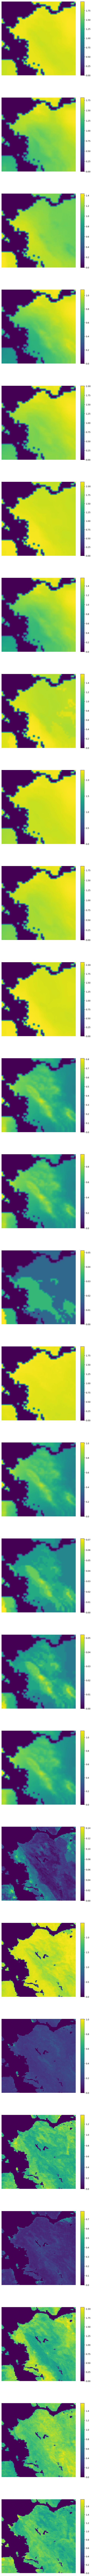

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,patch.shape[0]*8))
plt.subplots_adjust(hspace=0.3)
# plt.suptitle("Daily closing prices", fontsize=18, y=0.95)

# loop through the length of tickers and keep track of index
for i in range (0,patch.shape[0]):
    RGB_image = patch[i].unsqueeze(dim=0) * 3 #-> Remove first dim (channel) and then fake convert to RGB
    # add a new subplot iteratively
    ax = plt.subplot(patch.shape[0], 1, i + 1)
    shw = ax.imshow(RGB_image.permute(1, 2, 0))#, vmax=1.0)
    bar = plt.colorbar(shw)
    ax.axis('off')

In [123]:
import IPython
import torch
import torchvision.transforms as T

to_pil = T.ToPILImage()


# t = torch.from_numpy(patch[20,:,:])
display = to_pil(patch[-1,:,:])
# display.show()
display.save('test.png')

In [124]:
del extractor

import gc
gc.collect()

1168